# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to develop a machine learning model that can classify chest X-ray images into three categories: COVID-19, Normal, and Pneumonia. The dataset, sourced from Mendeley, contains 603 images across these three classes. This notebook involves data preprocessing, Roboflow-assisted image cleaning, feature extraction (both pixel and texture-based), and classification using multiple ML models.

In [30]:
import os
import time
import zipfile
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from roboflow import Roboflow
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

### Set Constants
In this section, we load the necessary API keys (in this case, the Roboflow API key) from a .env file using the dotenv package. We also set a constant for random state, so that the analysis is reproducable.

In [31]:
load_dotenv()
ROBOFLOW_KEY = os.getenv("ROBOFLOW_API_KEY")

RANDOM_STATE = 42

## Download and Unzip Images
This step checks whether the dataset exists locally. If not, it downloads and unzips the dataset into a structured directory format. During extraction, file and folder names are sanitized for consistency.

In [32]:
dataroot = "dataroot/"
zip_path = dataroot + "fvk7h5dg2p-1.zip"
raw_path = dataroot + "raw/"

def download_data(url):
    '''
    download_data: This function creates a directory nammed 'dataroot' and downloads the zip file containing the X-ray images using its URL.
    It then saves the zip file to the 'dataroot' directory.
    
    Args:
        url (str): The URL needed to download the zip file.
    
    Return:
        The function doesn't return anything.
    '''
    
    response = requests.get(url, params={"downloadformat": "zip"})
    os.makedirs(dataroot)
    with open(zip_path, "wb") as file:
        file.write(response.content)


def unzip_data():
    '''
    unzip_data: This function unzips the zip file. It creates a folder named 'raw' within the 'dataroot' directory. The 'raw'
    folder in turn contains three different folders named COVID-19, Pneumonia and Normal. The COVID-19 folder contains the X-rays
    for patients with COVID-19, the Pneumonia folder contains the X-rays for patients with Pneumonia and the Normal folder contains
    the X-rays for patients with normal X-rays (healthy individuals).
    
    Args:
        There are no arguments.
    
    Return:
        The function doesn't return anything.
    '''
    if os.path.isdir(dataroot):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for file in zip_ref.namelist():
                sanitized_name = file.strip().replace("\\", "/") #Ensure consistent path format
                #Sanitize folder names
                if sanitized_name.startswith("Normal "):
                    sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)
                if sanitized_name.startswith("COVID-19"):
                    sanitized_name = sanitized_name.replace("COVID-19 cases", "COVID-19", 1)
                target_path = os.path.join(raw_path, sanitized_name)
                #Skip directories (avoid trying to open them as files)
                if file.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                    continue
                #Ensure the parent directory exists before extracting
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                # Extract file safely
                with zip_ref.open(file) as source, open(target_path, "wb") as target:
                    target.write(source.read())

        os.remove(zip_path) #Remove zip file
        print("Extraction completed successfully.")

In [33]:
#Download and unzip the zip file
if not os.path.isdir(dataroot):
    download_data("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip")
    unzip_data()
else:
    print("dataroot already exists.")

dataroot already exists.


## Cleaning with Roboflow
We connect to a Roboflow object detection model to preprocess the dataset. This involves resizing each image and zeroing out regions identified by Roboflow as irrelevant or noisy, thus enhancing the signal for classification.

In [ ]:
#Connecting to the model on roboflow
rf = Roboflow(api_key=ROBOFLOW_KEY)
project = rf.workspace().project("cap-project-u384k")
model = project.version(1).model

### Image Cleaning Strategy
Images are resized to a uniform resolution to meet Roboflow API constraints. A retry mechanism is implemented for API robustness, and predictions are used to black out detected regions in the images.

In [35]:
def safe_predict(model, img, retries=3):
    '''
    safe_predict: This function is for running the roboflow object detection model.
    
    Args:
        model (roboflow model): The connection that was established to the roboflow model using the API key.
        img (png, jpg, jpeg): The X-ray image the model is being run on.
        retries (int): The number of times to try to connect to roboflow servers.
    
    Return:
        The function doesn't return anything.
    '''
    for attempt in range(retries):
        try:
            return model.predict(img, confidence=20, overlap=30).json()
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            time.sleep(2 ** attempt) #exponential backoff
    raise RuntimeError("Max retries exceeded for model prediction.")

def clean_x_rays(input_folder, output_folder):
    '''
    clean_x_rays: This function loads the X-ray images from the input folder. It then runs the roboflow object detection 
    model on the images to detect medical leads and text. It then sets the pixel values of those pixels that the model identifies
    as either leads or text to zero (i.e., black). Finally, it saves the cleaned X-ray images to the output_folder.
    
    Args:
        input_folder (str): Either "dataroot/raw/COVID-19", "dataroot/raw/Pneumonia" or "dataroot/raw/Normal"
        output_folder (str): Either "dataroot/cleaned/COVID-19", "dataroot/cleaned/Pneumonia" or "dataroot/cleaned/Normal"
    
    Return:
        The function doesn't return anything.
    '''
    os.makedirs(output_folder, exist_ok=True)
    for item in os.walk(input_folder):
        root = item[0]
        files = item[2]
        for file in files:
            if not os.path.exists(os.path.join(output_folder, file)): #Skip over already processed files
                time.sleep(3)
                img = cv.imread(os.path.join(root, file))
                img = resize(img, (512, 512), anti_aliasing=True, preserve_range=True).astype(np.uint8)
                result = safe_predict(model, img)
                for i in range(len(result['predictions'])):
                    prediction = result['predictions'][i]
                    roi_x = int(prediction['x'] - prediction['width']/2)
                    roi_y = int(prediction['y'] - prediction['height']/2)
                    roi_width = int(prediction['width'])
                    roi_height = int(prediction['height'])
                    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0
                cv.imwrite(os.path.join(output_folder, file), img)

### Process All Images if Not Already Cleaned
This step checks if the cleaned folders exist. If not, it processes all raw images using the cleaning logic described above, skipping over any files already cleaned.

In [36]:
raw_path = "dataroot/raw/"
clean_path = "dataroot/cleaned/"
if not all([os.path.isdir(clean_path + "COVID-19"),
            os.path.isdir(clean_path + "Normal"),
            os.path.isdir(clean_path + "Pneumonia")]):
    clean_x_rays(raw_path + "COVID-19", clean_path + "COVID-19")
    print("COVID-19 Images Processed")
    clean_x_rays(raw_path + "Normal", clean_path + "Normal")
    print("Normal Images Processed")
    clean_x_rays(raw_path + "Pneumonia", clean_path + "Pneumonia")
    print("Pneumonia Images Processed")

### View Raw Images
Here we visualize sample images from the raw dataset across all three classes to understand the visual structure and differences among them.

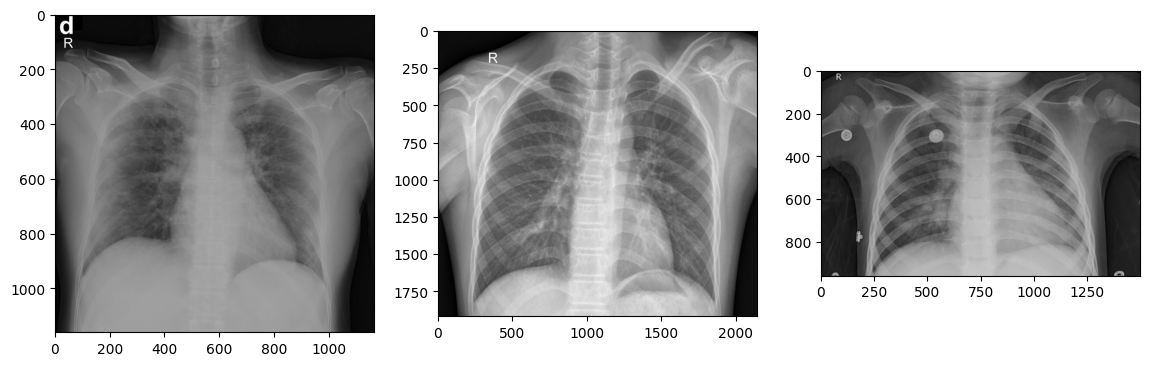

In [37]:
# Load and preview raw images
raw_img_covid     = cv.imread(raw_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
raw_img_normal    = cv.imread(raw_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
raw_img_pneumonia = cv.imread(raw_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(raw_img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(raw_img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(raw_img_pneumonia,cmap='gray')

### View Cleaned Images
This section provides a side-by-side view of cleaned images to compare the effectiveness of the Roboflow cleaning process.

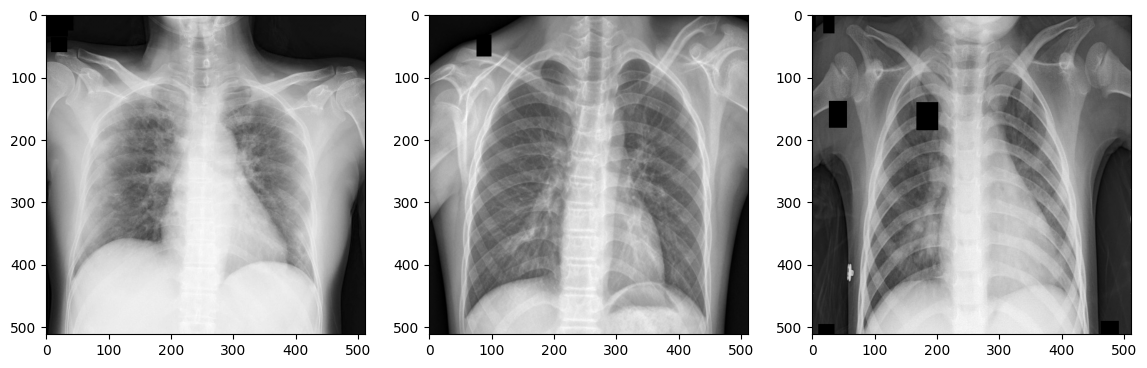

In [38]:

# Load and preview raw images
clean_img_covid     = cv.imread(clean_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
clean_img_normal    = cv.imread(clean_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
clean_img_pneumonia = cv.imread(clean_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(2,3,1)
plt.imshow(clean_img_covid,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(clean_img_normal,cmap='gray')
plt.subplot(2,3,3)
plt.imshow(clean_img_pneumonia,cmap='gray')


# Images and Their Corresponding Labels
We load all cleaned images, assign them class labels based on their directory, and return the images along with metadata. This is crucial for downstream machine learning tasks.

In [39]:
def load_chest_xray_data(data_dir):
    '''
    load_chest_xray_data: This function loads all the cleaned images and assigns them a class label based on their
    directory and then returns the images along with metadata.
    
    Args:
        data_dir (str): The directory containing all of the cleaned images (i.e., "dataroot/cleaned/")
            
    Return:
        images (list) : List of image arrays
        labels (list): List of corresponding labels
        label_map (dict): Dictionary mapping label indices to label names
        image_paths (list): List of image file paths
    '''
    # Get all subdirectories (class labels)
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # Create a label mapping
    label_map = {i: label for i, label in enumerate(subfolders)}
    
    images = []
    labels = []
    image_paths = []
    
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Loop through each subfolder (class)
    for label_idx, subfolder in enumerate(subfolders):
        class_dir = os.path.join(data_dir, subfolder)
        print(f"Loading images from {subfolder}...")
        
        # Get all image files
        img_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            img_paths.extend(glob(os.path.join(class_dir, ext)))
        
        # Load each image
        for img_path in img_paths:
            try:
                # Read image and convert to grayscale
                img = io.imread(img_path)
                if len(img.shape) > 2:  # Check if the image has more than 2 dimensions
                    img = np.mean(img, axis=2).astype(np.uint8)  # Convert to grayscale
                
                images.append(img)
                labels.append(label_idx)
                image_paths.append(img_path)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(img_paths)} images from {subfolder}")
    
    print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [40]:
images, labels, label_map, image_paths = load_chest_xray_data(clean_path)

Found 3 classes: ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


Function for getting the analytics output for the model based on the mode, and test data.

In [41]:
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import ipywidgets as widgets
import re

def get_model_analytics(model, x_test, y_test):
    # Make predictions
    y_pred = model.predict(X=x_test)
    
    # For SVM, ensure 'probability=True' to get predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X=x_test)
    else:
        # If no predict_proba, use decision function (for SVM)
        y_prob = model.decision_function(X=x_test)
        # For multi-class classification, we need to convert decision_function to probabilities
        encoder = OneHotEncoder()
        y_prob = encoder.fit_transform(y_prob.reshape(-1, 1)).toarray()

    # Split model class name and print all caps for section title
    if model.__class__.__name__ == "SVC":
        print(f"{model.__class__.__name__} MODEL ANALYTICS")
        print("-" * 50)
    else:
        model_name = re.split(r'(?=[A-Z])', model.__class__.__name__)
        model_name = ' '.join(filter(None, model_name))
        print(f"{model_name.upper()} MODEL ANALYTICS")
        print("-" * 50)

    # Print per-class AUC scores
    print(f"ROC-AUC Scores with OVR:\n{'ROC-AUC':>23}\n")
    for cls, score in zip(list(label_map.values()),
                          roc_auc_score(y_true=y_test, 
                                        y_score=y_prob, 
                                        multi_class='ovr', 
                                        average=None)):
        print(f"{cls:>12} {score:>10.4f}")

    # Print macro average AUC
    macro_auc = roc_auc_score(y_true=y_test, 
                          y_score=y_prob, 
                          multi_class='ovr', 
                          average='macro')
    print(f"\n{'macro avg':>12} {macro_auc:>10.4f}")

    # classification report
    print("\n\nClassification Report:")
    print(classification_report(y_true=y_test,
                                y_pred=y_pred,
                                target_names=list(label_map.values()),
                                digits=4))
        
    # Confustion matrix
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                            y_pred=y_pred,
                                            display_labels=label_map.values(),
                                            cmap=plt.cm.Blues,
                                            colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

def run_model_analytics_in_column(model, x_test, y_test, col_list):
    out = widgets.Output()
    with out:
        get_model_analytics(model, x_test, y_test)
    col_list.append(out)

def show_model_analytics_columns(col_list, columns_per_row=4, border_style="1px solid black", border_radius="8px", padding="10px"):
    rows = []
    for i in range(0, len(col_list), columns_per_row):
        children = []
        for out in col_list[i:i+columns_per_row]:
            # Each output wrapped in a Box with a border
            child = widgets.Box(
                [out],
                layout=widgets.Layout(
                    border=border_style,
                    border_radius=border_radius,
                    padding=padding,
                    margin=f"10px 10px",  # spacing between columns
                    width='100%',  # Let it stretch inside the row
                )
            )
            children.append(child)
        row = widgets.HBox(children, layout=widgets.Layout(align_items='flex-start'))
        rows.append(row)
    display(widgets.VBox(rows))

def show_feature_importance(model, feature_importances, feature_inidicies, feature_names):
    # Plot ALL features
    plt.figure(figsize=(20, 12))  # Larger figure for 48 features
    plt.title(f"{model.__class__.__name__} GLCM Feature Importance (Permutation Method)", fontsize=16)
    plt.bar(range(len(feature_importances)), feature_importances[feature_inidicies], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in feature_inidicies], rotation=90, fontsize=10)
    plt.xlabel("Features", fontsize=14)
    plt.ylabel("Importance", fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Flattened Images Section
Images are flattened into 1D arrays to serve as features for machine learning models. Labels are preserved, and a train-test split is applied. Feature scaling is done using StandardScaler.

In [42]:
df = pd.DataFrame({
    "image": [img.flatten() for img in images],
    "label": labels})

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(
    np.array(df["image"].tolist()), 
    df["label"], 
    test_size=0.2, 
    stratify=labels, 
    random_state=RANDOM_STATE)

X_train_flat = StandardScaler().fit_transform(X_train_flat)
X_test_flat = StandardScaler().fit_transform(X_test_flat)

Summary statistics of flattened image data

In [43]:
# Create a DataFrame with per-image stats
flat_summary_df = pd.DataFrame({
    "label": pd.Series(labels).map(label_map),
    "mean_pixel": [np.mean(img) for img in df["image"]],
    "std_pixel": [np.std(img) for img in df["image"]],
    "min_pixel": [np.min(img) for img in df["image"]],
    "max_pixel": [np.max(img) for img in df["image"]],
    "nonzero_pixels": [np.count_nonzero(img) for img in df["image"]]
})

# Group by label and calculate the mean of each stat
flat_summary_df.groupby("label").mean()

,mean_pixel,std_pixel,min_pixel,max_pixel,nonzero_pixels
label,,,,,
COVID-19,134.489708,55.123013,2.004525,234.248869,251150.457014
Normal,123.298157,60.228426,0.021368,240.384615,246386.106838
Pneumonia,122.062239,62.178421,0.000000,233.459459,240538.344595


# Perform Machine Learning Techniques on Flattened Images

### Logistic Regresssion on Flattened Images
We apply Logistic with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'C': 0.1, 'max_iter': 100}

Optimal F1-macro score:: 0.8822432318414934
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9917
      Normal     0.9577
   Pneumonia     0.9714

   macro avg     0.9736


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9545    0.9545    0.9545        44
      Normal     0.8864    0.8298    0.8571        47
   Pneumonia     0.8182    0.9000    0.8571        30

    accuracy                         0.8926       121
   macro avg     0.8864    0.8948    0.8896       121
weighted avg     0.8943    0.8926    0.8926       121



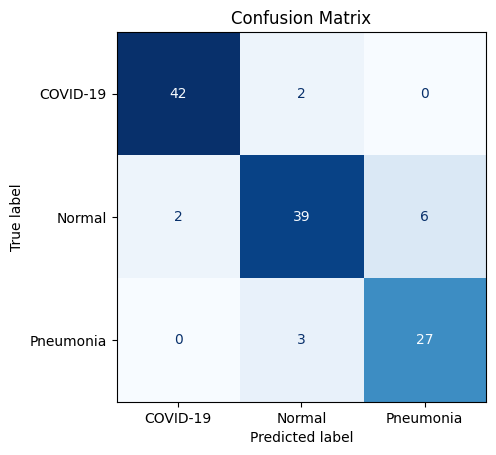

In [14]:
from sklearn.linear_model import LogisticRegression

lr_flat = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    lr_flat,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1, 
    verbose=0 
)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
lr_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(lr_flat, X_test_flat, y_test_flat)

### Random Forest on Flattened Images
We apply a Random Forest classifier with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 75}

Optimal F1-macro score:: 0.8922569768973417
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9876
      Normal     0.9563
   Pneumonia     0.9425

   macro avg     0.9621


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9268    0.8636    0.8941        44
      Normal     0.7627    0.9574    0.8491        47
   Pneumonia     0.9048    0.6333    0.7451        30

    accuracy                         0.8430       121
   macro avg     0.8648    0.8181    0.8294       121
weighted avg     0.8576    0.8430    0.8397       121



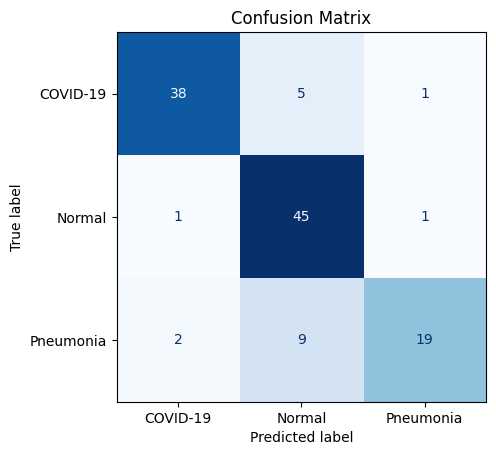

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_flat = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
    'max_depth': range(5, 51, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 5)}

grid_search = GridSearchCV(
    rf_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
rf_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(rf_flat, X_test_flat, y_test_flat)

### SVC on Flattened Images
An SVC classifier is trained with different kernels and hyperparameters to find the best fit for the flattened image data.

Optimal Hyperparameters:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

Optimal F1-macro score: 0.878092466903375
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9944
      Normal     0.9638
   Pneumonia     0.9659

   macro avg     0.9747


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9333    0.9545    0.9438        44
      Normal     0.8837    0.8085    0.8444        47
   Pneumonia     0.7879    0.8667    0.8254        30

    accuracy                         0.8760       121
   macro avg     0.8683    0.8766    0.8712       121
weighted avg     0.8780    0.8760    0.8759       121



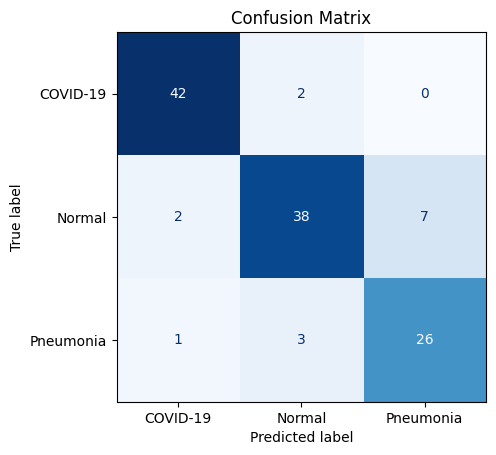

In [16]:
from sklearn.svm import SVC

svc_flat = SVC(probability=True, random_state=RANDOM_STATE)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(
    svc_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(svc_flat, X_test_flat, y_test_flat)

### k-Nearest Neighbors on Flattened Images
We test the performance of a k-NN classifier by tuning the number of neighbors using grid search.

Optimal Hyperparameters:
{'n_neighbors': 12}

Optimal F1-macro score:: 0.819094607629761
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9951
      Normal     0.9130
   Pneumonia     0.9366

   macro avg     0.9483


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9750    0.8864    0.9286        44
      Normal     0.7805    0.6809    0.7273        47
   Pneumonia     0.6250    0.8333    0.7143        30

    accuracy                         0.7934       121
   macro avg     0.7935    0.8002    0.7900       121
weighted avg     0.8127    0.7934    0.7973       121



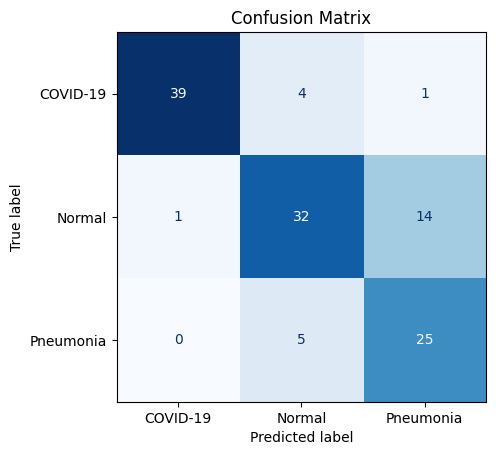

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_flat = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 40)}

grid_search = GridSearchCV(
    knn_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
knn_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(knn_flat, X_test_flat, y_test_flat)

# GLCM Section
## Texture-Based Feature Extraction
We extract GLCM (Gray-Level Co-occurrence Matrix) features from each image, which are effective for texture analysis in medical images. Features include contrast, energy, and correlation at multiple distances and angles.

In [45]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2, 3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    '''
    extract_glcm_features_df: Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Args:
        images (list): List of image arrays
        labels (list): List of corresponding labels
        image_paths (list): List of image file paths or IDs
        target_size (tuple): Size to resize all images to (width, height)
        distances (list): List of distances for GLCM calculation
        angles (list): List of angles for GLCM calculation
        g_levels (int): Number of gray levels to use for GLCM calculation (default is 256)

    Return:
        df (pandas DataFrame): DataFrame containing image_id, label, and all GLCM features
        glcm (numpy ndarray): co-occurrence Matrix
    '''
    # GLCM properties to calculate
    properties = ['contrast', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

In [46]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1, 5, 10],
    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


### Train-Test Split on GLCM Data
We split the extracted GLCM features into training and testing sets for model evaluation.

In [47]:
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
    glcm_df.drop(columns=['image_id', 'label'], axis=1),
    glcm_df['label'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=glcm_df['label']
)

X_train_glcm = StandardScaler().fit_transform(X_train_glcm)
X_test_glcm = StandardScaler().fit_transform(X_test_glcm)

Summary statistics of GLCM data broken down in groupings by property type, and distances.

In [88]:
glcm_summary_df = glcm_df.drop(columns=['image_id']).copy()
glcm_summary_df['label'] = pd.Series(glcm_summary_df['label']).map(label_map)
grouped_stats = glcm_summary_df.groupby('label').agg(['mean', 'std', 'min', 'max'])

distances = ['1', '5', '10']
properties = ['contrast', 'energy', 'correlation']
for prop in properties:
    for dist in distances:
        display(grouped_stats.filter(regex=fr'{prop}_d{dist}(?!\d)', axis=1))

contrast_d1_a0                                   contrast_d1_a45  \
                    mean        std        min         max            mean   
label                                                                        
COVID-19       32.591725  27.696591   3.542694  194.315367       61.084996   
Normal         35.166668  11.317371  19.095072   97.985002       49.294792   
Pneumonia      32.228109   9.189350  13.365315   64.773178       47.929479   

                                            contrast_d1_a90             \
                 std        min         max            mean        std   
label                                                                    
COVID-19   43.111253   8.145680  263.443767       33.293328  25.992421   
Normal     14.132794  27.560924  112.948959       19.616468   5.990792   
Pneumonia  15.096364  18.302055  114.542771       24.417580   7.781984   

                                 contrast_d1_a135                        \
                 min         max             mean        std        min   
label                                                                     
COVID-19    5.079600  150.478867        61.421794  43.385297   8.993693   
Normal     10.113212   70.127607        50.164819  14.346129  29.028718   
Pneumonia  10.690768   64.250990        48.344166  15.156328  21.622807   

                       
                  max  
label                  
COVID-19   269.746830  
Normal     125.368580  
Pneumonia  124.727153

contrast_d5_a0                                      contrast_d5_a45  \
                    mean         std         min          max            mean   
label                                                                           
COVID-19      226.065195  172.254126   37.035133  1458.844104      284.409001   
Normal        340.657678   94.051630  181.481813   814.849359      318.925021   
Pneumonia     265.344164   74.755588  132.408438   522.568714      251.362638   

                                               contrast_d5_a90              \
                  std         min          max            mean         std   
label                                                                        
COVID-19   189.280405   48.410297  1401.501093      207.983388  141.785451   
Normal      87.206926  171.322203   706.580515      176.978856   49.038679   
Pneumonia   80.975570  110.338916   566.573846      144.546871   55.599319   

                                 contrast_d5_a135                          \
                 min         max             mean         std         min   
label                                                                       
COVID-19   41.087151  844.656308       287.901344  192.473418   43.547167   
Normal     80.568960  553.829997       324.725584   87.943199  176.936779   
Pneumonia  57.019450  406.056521       255.842747   82.922935  130.279861   

                        
                   max  
label                   
COVID-19   1401.131123  
Normal      772.615855  
Pneumonia   627.299011

contrast_d10_a0                                       \
                     mean         std         min          max   
label                                                            
COVID-19       493.698915  323.861884   82.945149  2788.861476   
Normal         819.322604  196.980606  446.304991  1798.999790   
Pneumonia      655.139833  175.027055  311.859772  1208.941690   

          contrast_d10_a45                                       \
                      mean         std         min          max   
label                                                             
COVID-19        502.986292  310.567629   94.422308  2471.241576   
Normal          626.732393  160.456095  342.533116  1346.313593   
Pneumonia       493.224769  150.825383  236.383217  1030.981178   

          contrast_d10_a90                                       \
                      mean         std         min          max   
label                                                             
COVID-19        404.686296  263.169336   86.561753  1760.324176   
Normal          380.124537  102.463280  175.599858  1201.151892   
Pneumonia       301.220412  115.126666  117.824728   765.656223   

          contrast_d10_a135                                       
                       mean         std         min          max  
label                                                             
COVID-19         511.738961  315.660814   84.510197  2430.311150  
Normal           636.172965  159.556356  356.154753  1350.112848  
Pneumonia        502.131490  153.536661  238.975465  1118.603560

energy_d1_a0                               energy_d1_a45            \
                  mean       std       min       max          mean       std   
label                                                                          
COVID-19      0.068914  0.064633  0.019212  0.506081      0.065688  0.064758   
Normal        0.067460  0.037503  0.019589  0.205913      0.066257  0.038041   
Pneumonia     0.086379  0.045566  0.019642  0.238570      0.085202  0.046174   

                              energy_d1_a90                                \
                min       max          mean       std       min       max   
label                                                                       
COVID-19   0.018553  0.501600      0.070440  0.064595  0.020642  0.504980   
Normal     0.017337  0.201739      0.071143  0.037735  0.020959  0.205716   
Pneumonia  0.018079  0.238458      0.089699  0.045375  0.021768  0.242039   

          energy_d1_a135                                
                    mean       std       min       max  
label                                                   
COVID-19        0.065675  0.064771  0.018627  0.501955  
Normal          0.066242  0.038044  0.017416  0.201797  
Pneumonia       0.085156  0.046183  0.018065  0.238501

energy_d5_a0                               energy_d5_a45            \
                  mean       std       min       max          mean       std   
label                                                                          
COVID-19      0.057259  0.063956  0.013674  0.495696      0.055611  0.063363   
Normal        0.054156  0.036011  0.011339  0.191221      0.055991  0.036884   
Pneumonia     0.073495  0.045002  0.012086  0.225700      0.075007  0.045905   

                              energy_d5_a90                                \
                min       max          mean       std       min       max   
label                                                                       
COVID-19   0.013393  0.489034      0.058927  0.064778  0.014839  0.494256   
Normal     0.010899  0.183307      0.065313  0.039869  0.012546  0.192946   
Pneumonia  0.012075  0.228857      0.083507  0.047690  0.015311  0.239860   

          energy_d5_a135                                
                    mean       std       min       max  
label                                                   
COVID-19        0.055660  0.063371  0.013347  0.489664  
Normal          0.055955  0.036890  0.011018  0.183399  
Pneumonia       0.074923  0.045850  0.012045  0.229221

energy_d10_a0                               energy_d10_a45  \
                   mean       std       min       max           mean   
label                                                                  
COVID-19       0.051302  0.061072  0.011199  0.483584       0.050134   
Normal         0.042353  0.031588  0.009054  0.173381       0.048191   
Pneumonia      0.061052  0.041234  0.009934  0.208364       0.066853   

                                        energy_d10_a90                      \
                std       min       max           mean       std       min   
label                                                                        
COVID-19   0.060806  0.011402  0.474258       0.053396  0.063205  0.011855   
Normal     0.034277  0.008980  0.163078       0.063084  0.040242  0.010262   
Pneumonia  0.044090  0.010267  0.218884       0.080198  0.048222  0.013274   

                    energy_d10_a135                                
                max            mean       std       min       max  
label                                                              
COVID-19   0.478505        0.050216  0.060792  0.011311  0.475381  
Normal     0.185239        0.048144  0.034287  0.009141  0.163220  
Pneumonia  0.238215        0.066750  0.043958  0.010221  0.219497

correlation_d1_a0                               correlation_d1_a45  \
                       mean       std       min       max               mean   
label                                                                          
COVID-19           0.995138  0.004984  0.952597  0.999572           0.990921   
Normal             0.995574  0.001526  0.988300  0.998110           0.993784   
Pneumonia          0.996291  0.001622  0.986340  0.998747           0.994496   

                                        correlation_d1_a90            \
                std       min       max               mean       std   
label                                                                  
COVID-19   0.007494  0.934702  0.999026           0.995027  0.004683   
Normal     0.001979  0.985968  0.997129           0.997509  0.000908   
Pneumonia  0.002378  0.982009  0.997977           0.997223  0.001143   

                              correlation_d1_a135                      \
                min       max                mean       std       min   
label                                                                   
COVID-19   0.957428  0.999466            0.990880  0.007519  0.935495   
Normal     0.993242  0.999009            0.993669  0.002039  0.985483   
Pneumonia  0.991516  0.999108            0.994452  0.002417  0.980915   

                     
                max  
label                
COVID-19   0.998909  
Normal     0.997072  
Pneumonia  0.997938

correlation_d5_a0                              correlation_d5_a45  \
                       mean       std       min      max               mean   
label                                                                         
COVID-19           0.967857  0.021935  0.819712  0.99471           0.958914   
Normal             0.956436  0.012841  0.912207  0.97928           0.959253   
Pneumonia          0.969391  0.011359  0.919452  0.98608           0.970976   

                                        correlation_d5_a90            \
                std       min       max               mean       std   
label                                                                  
COVID-19   0.025690  0.840355  0.991914           0.969775  0.019835   
Normal     0.011831  0.921942  0.980590           0.977493  0.007603   
Pneumonia  0.011781  0.919885  0.988644           0.983495  0.007797   

                              correlation_d5_a135                      \
                min       max                mean       std       min   
label                                                                   
COVID-19   0.877972  0.993914            0.958480  0.026060  0.821413   
Normal     0.951125  0.990555            0.958478  0.012160  0.917356   
Pneumonia  0.948414  0.995122            0.970527  0.011942  0.918959   

                     
                max  
label                
COVID-19   0.991533  
Normal     0.980561  
Pneumonia  0.988231

correlation_d10_a0                                \
                        mean       std       min       max   
label                                                        
COVID-19            0.930238  0.038944  0.671725  0.984433   
Normal              0.893035  0.027292  0.799125  0.950495   
Pneumonia           0.923543  0.023624  0.834057  0.960744   

          correlation_d10_a45                                \
                         mean       std       min       max   
label                                                         
COVID-19             0.927389  0.039469  0.729820  0.983404   
Normal               0.918721  0.021804  0.849886  0.959071   
Pneumonia            0.942594  0.020864  0.873195  0.975605   

          correlation_d10_a90                                \
                         mean       std       min       max   
label                                                         
COVID-19             0.941252  0.034339  0.756874  0.986745   
Normal               0.951544  0.015514  0.902259  0.980926   
Pneumonia            0.965673  0.015639  0.905718  0.989908   

          correlation_d10_a135                                
                          mean       std       min       max  
label                                                         
COVID-19              0.926255  0.040081  0.703662  0.982648  
Normal                0.917419  0.022268  0.843708  0.959392  
Pneumonia             0.941740  0.020857  0.869318  0.974118

## Perform Machine Learning Techniques on GLCM Data

### Logistic Regression on GLCM Features
Logistic regression is applied with lbfgs solver to classify the GLCM features.

LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9580
      Normal     0.9311
   Pneumonia     0.9641

   macro avg     0.9511


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9219    0.8939    0.9077        66
      Normal     0.8841    0.8714    0.8777        70
   Pneumonia     0.8125    0.8667    0.8387        45

    accuracy                         0.8785       181
   macro avg     0.8728    0.8773    0.8747       181
weighted avg     0.8801    0.8785    0.8789       181



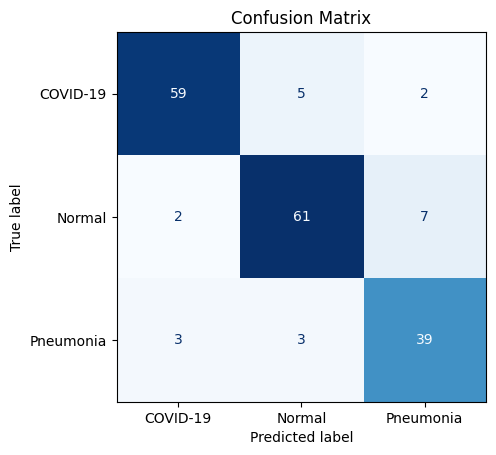

In [84]:
from sklearn.linear_model import LogisticRegression

lr_glcm = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)

# Train the classifier
lr_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(lr_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'C': 100, 'max_iter': 100}

Optimal F1-macro score: 0.8555011376401392
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9852
      Normal     0.9479
   Pneumonia     0.9690

   macro avg     0.9674


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9365    0.8939    0.9147        66
      Normal     0.8971    0.8714    0.8841        70
   Pneumonia     0.8200    0.9111    0.8632        45

    accuracy                         0.8895       181
   macro avg     0.8845    0.8922    0.8873       181
weighted avg     0.8923    0.8895    0.8900       181



lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


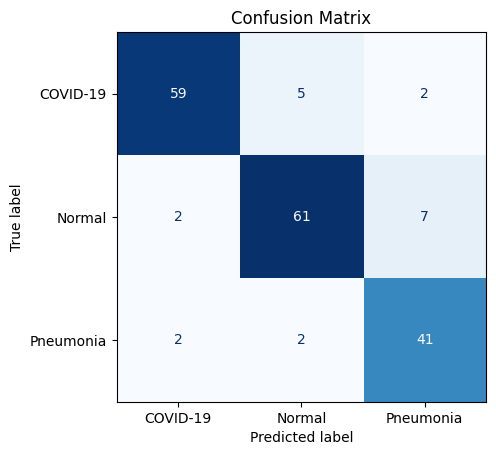

In [85]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    lr_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
lr_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(lr_glcm, X_test_glcm, y_test_glcm)

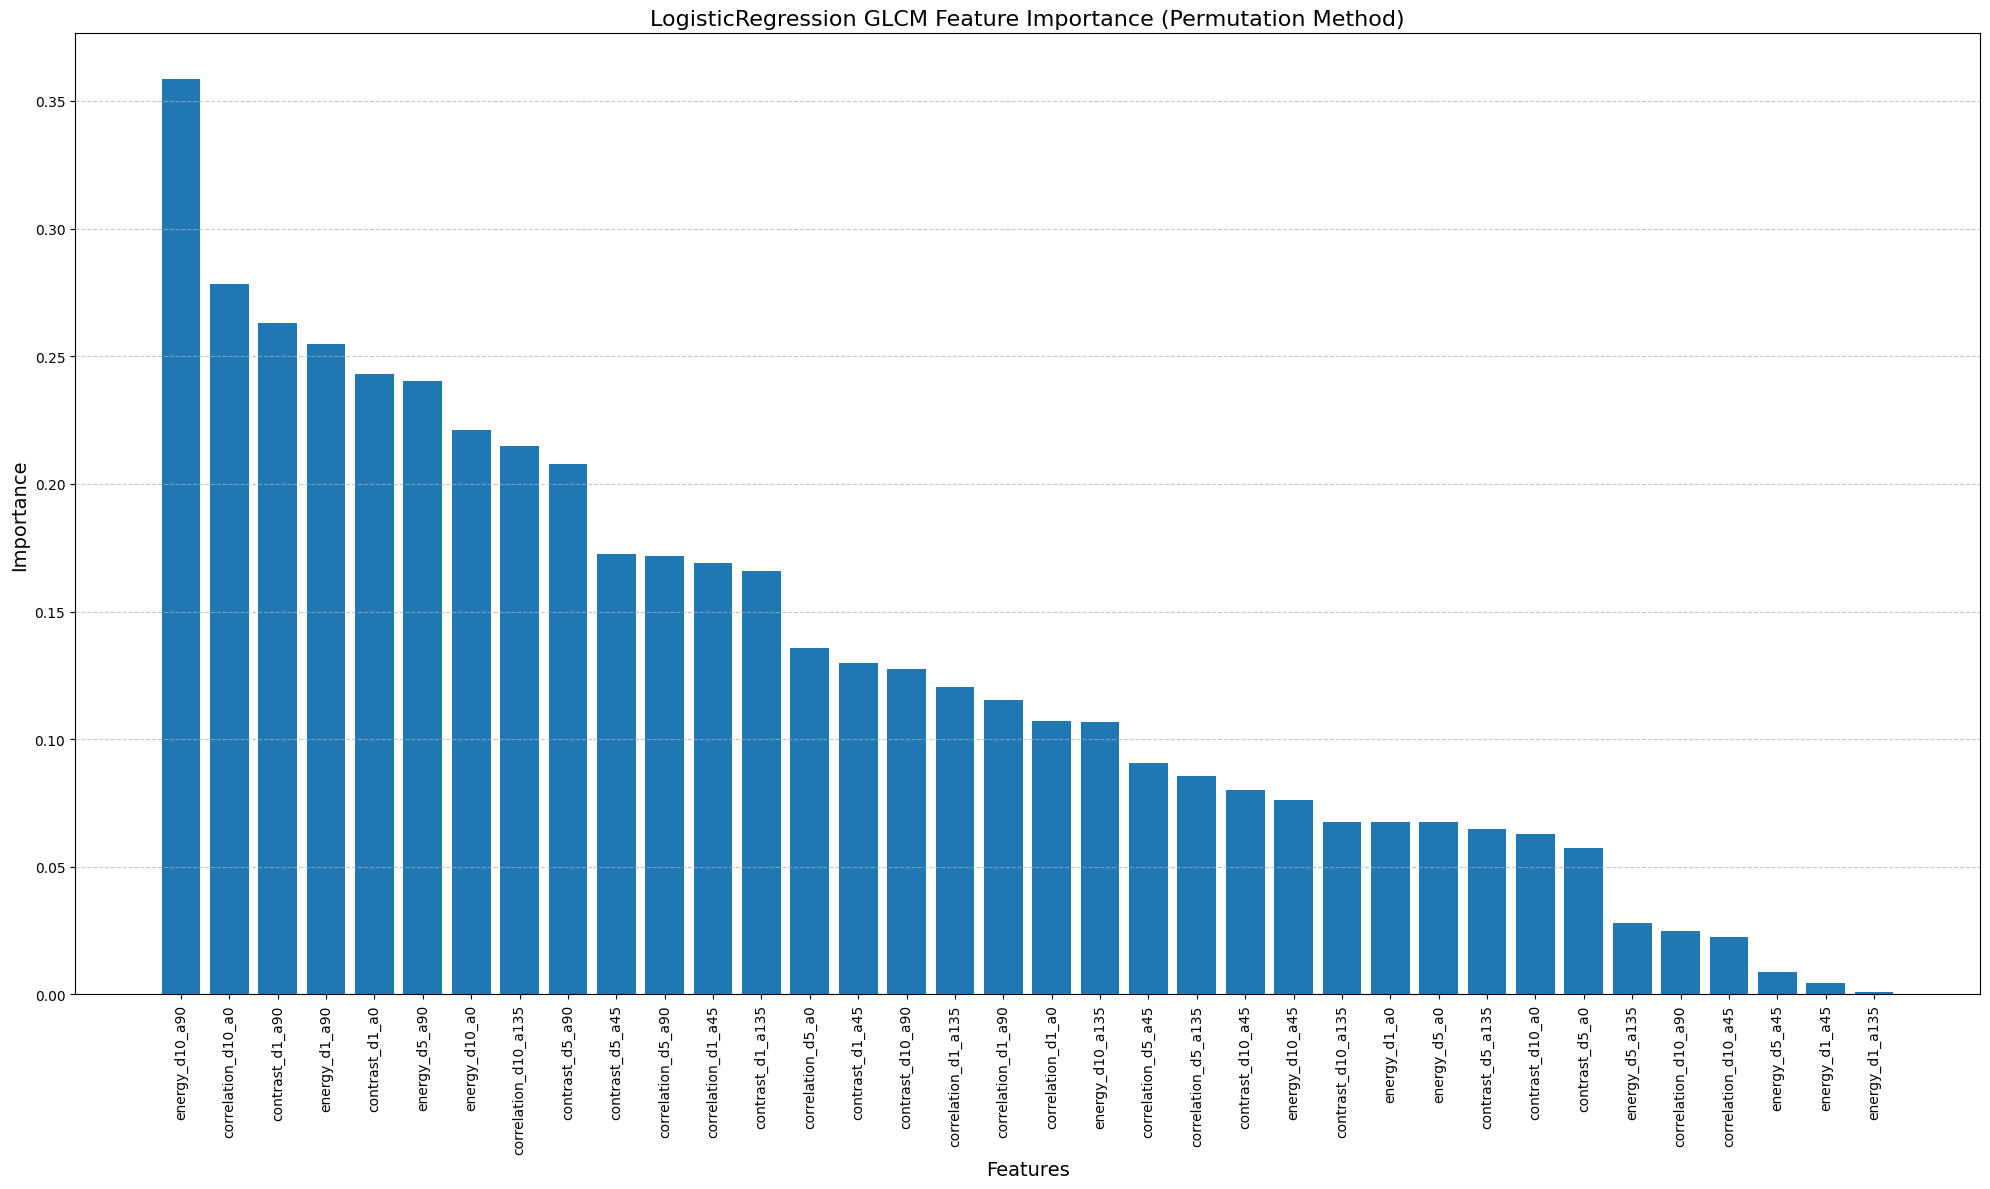

In [86]:
# permutation importance
result = permutation_importance(lr_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(lr_glcm, perm_importances, perm_indices, feature_names)

In [87]:
best_features = [feature_names[i] for i in perm_indices[:10]]
print(f"Best features: {best_features}")

# slice to 10 best features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_lr = X_train_glcm[:, perm_indices[:10]].copy()
X_test_glcm_lr = X_test_glcm[:, perm_indices[:10]].copy()

Best features: ['energy_d10_a90', 'correlation_d10_a0', 'contrast_d1_a90', 'energy_d1_a90', 'contrast_d1_a0', 'energy_d5_a90', 'energy_d10_a0', 'correlation_d10_a135', 'contrast_d5_a90', 'contrast_d5_a45']


Optimal Hyperparameters:
{'C': 10, 'max_iter': 100}

Optimal F1-macro score: 0.8391723353729372
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9708
      Normal     0.9358
   Pneumonia     0.9670

   macro avg     0.9578


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8806    0.8939    0.8872        66
      Normal     0.8592    0.8714    0.8652        70
   Pneumonia     0.8837    0.8444    0.8636        45

    accuracy                         0.8729       181
   macro avg     0.8745    0.8699    0.8720       181
weighted avg     0.8731    0.8729    0.8729       181



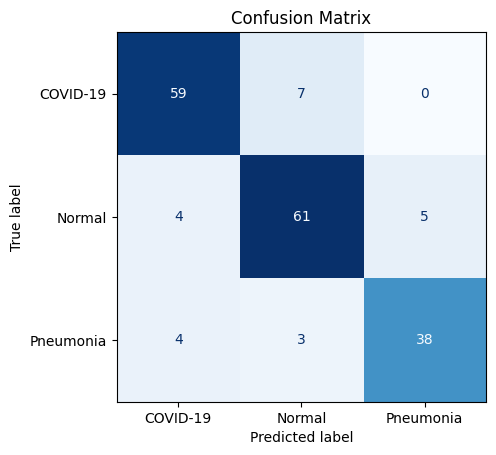

In [88]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    lr_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm_lr, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
lr_glcm_top_10 = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(lr_glcm_top_10, X_test_glcm_lr, y_test_glcm)

### Random Forest on GLCM Features
A Random Forest classifier is applied to the GLCM features, and performance is evaluated using classification metrics.

RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9500
      Normal     0.9416
   Pneumonia     0.9480

   macro avg     0.9465


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8261    0.8636    0.8444        66
      Normal     0.7922    0.8714    0.8299        70
   Pneumonia     0.8571    0.6667    0.7500        45

    accuracy                         0.8177       181
   macro avg     0.8251    0.8006    0.8081       181
weighted avg     0.8207    0.8177    0.8154       181



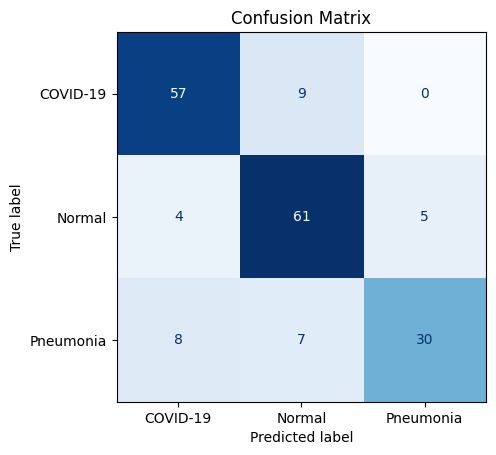

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf_glcm = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

# Train the classifier
rf_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 120}

Optimal F1-macro score: 0.831952596360056
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9500
      Normal     0.9393
   Pneumonia     0.9457

   macro avg     0.9450


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8308    0.8182    0.8244        66
      Normal     0.7722    0.8714    0.8188        70
   Pneumonia     0.8649    0.7111    0.7805        45

    accuracy                         0.8122       181
   macro avg     0.8226    0.8002    0.8079       181
weighted avg     0.8166    0.8122    0.8113       181



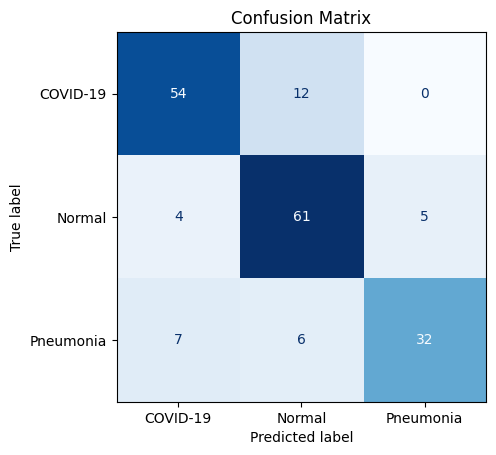

In [90]:
param_grid = {
    'max_depth': range(5, 101, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 5)
}

grid_search = GridSearchCV(
    rf_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
rf_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

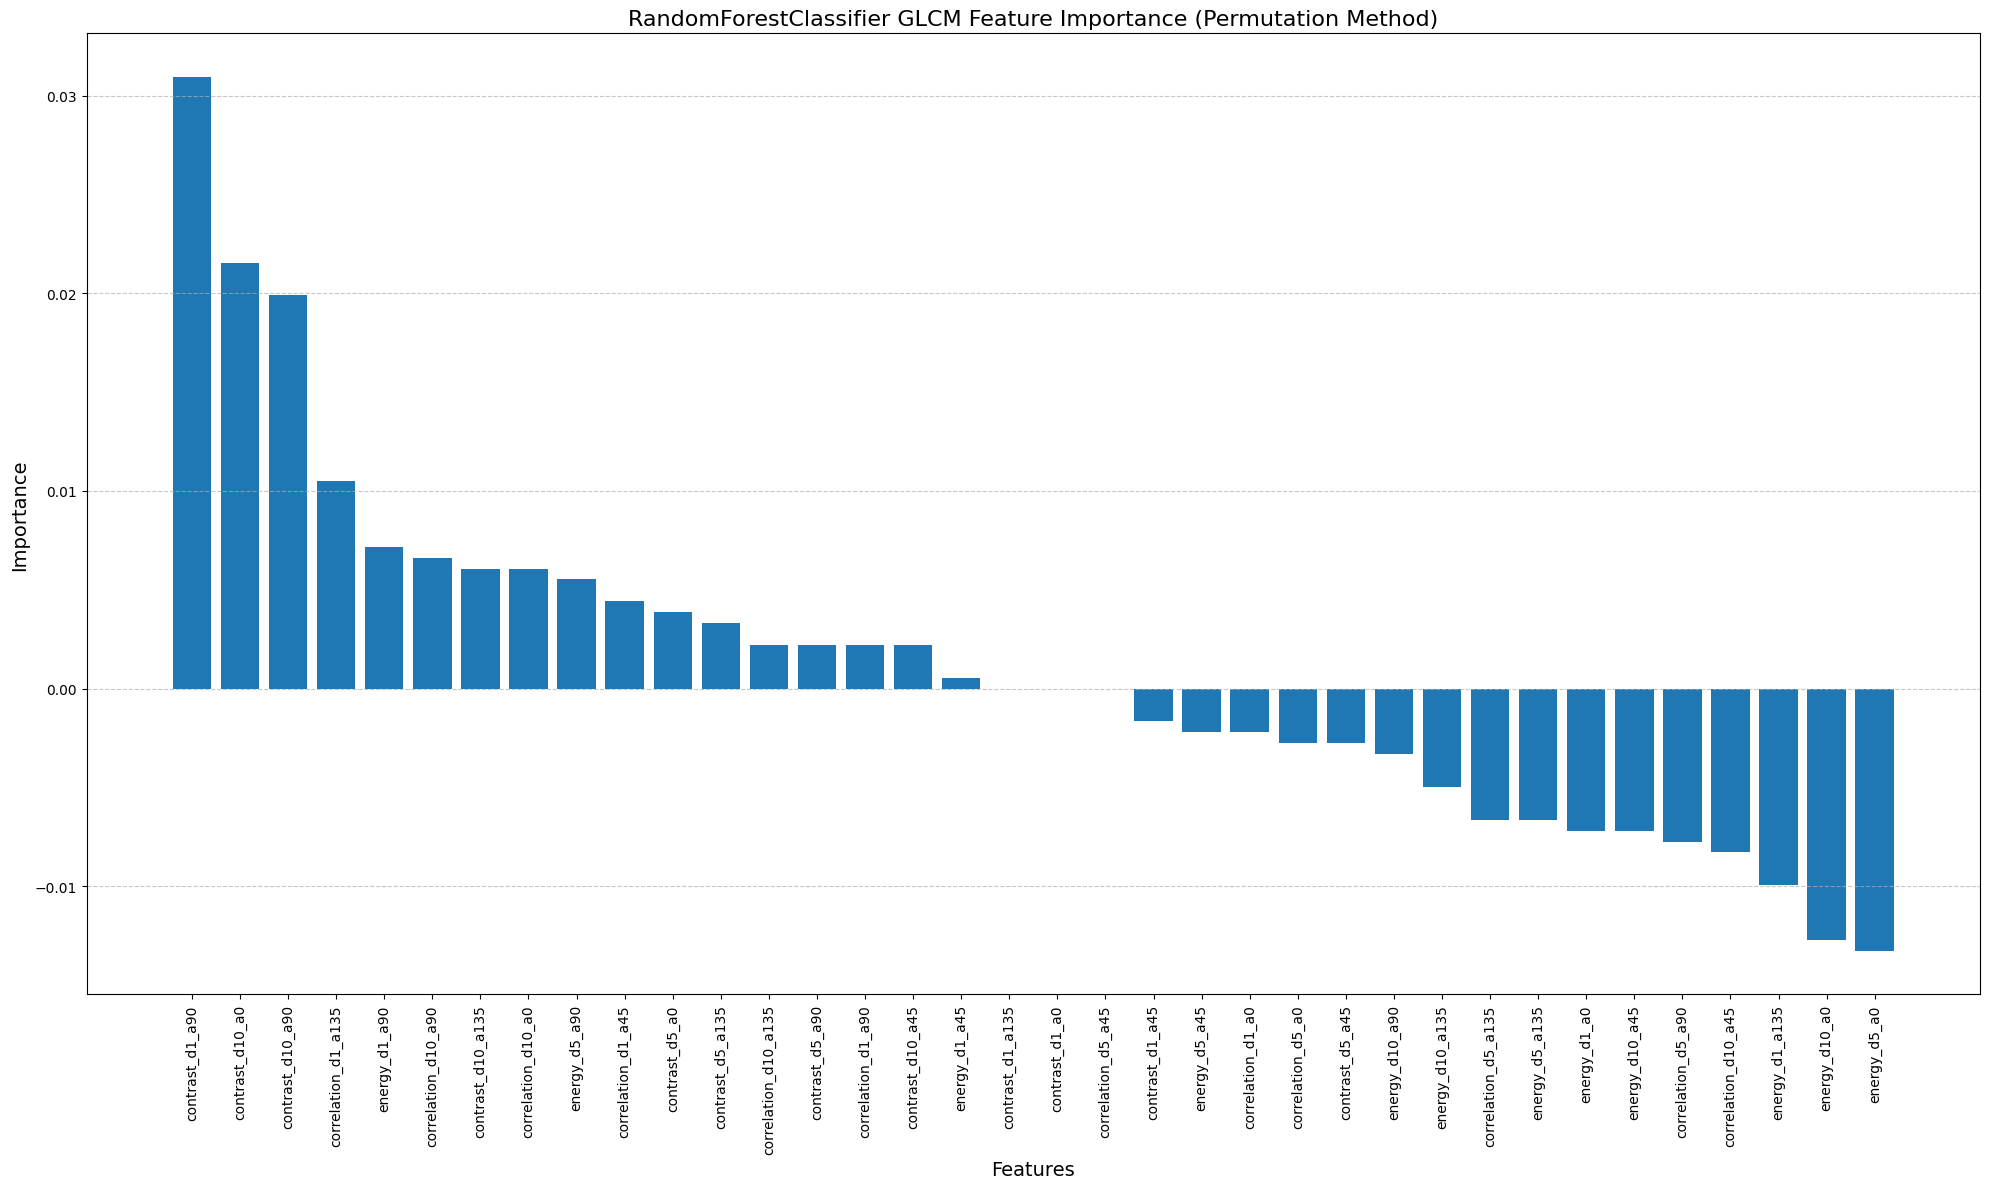

In [91]:
# permutation importance
result = permutation_importance(rf_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(rf_glcm, perm_importances, perm_indices, feature_names)

In [92]:
best_features = [feature_names[i] for i in perm_indices[:10]]
print(f"Best features: {best_features}")

# slice to 10 best features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_rf = X_train_glcm[:, perm_indices[:10]].copy()
X_test_glcm_rf = X_test_glcm[:, perm_indices[:10]].copy()

Best features: ['contrast_d1_a90', 'contrast_d10_a0', 'contrast_d10_a90', 'correlation_d1_a135', 'energy_d1_a90', 'correlation_d10_a90', 'contrast_d10_a135', 'correlation_d10_a0', 'energy_d5_a90', 'correlation_d1_a45']


Optimal Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 125}

Optimal F1-macro score: 0.8127754496668604
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9544
      Normal     0.9488
   Pneumonia     0.9497

   macro avg     0.9510


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8310    0.8939    0.8613        66
      Normal     0.8714    0.8714    0.8714        70
   Pneumonia     0.8250    0.7333    0.7765        45

    accuracy                         0.8453       181
   macro avg     0.8425    0.8329    0.8364       181
weighted avg     0.8451    0.8453    0.8441       181



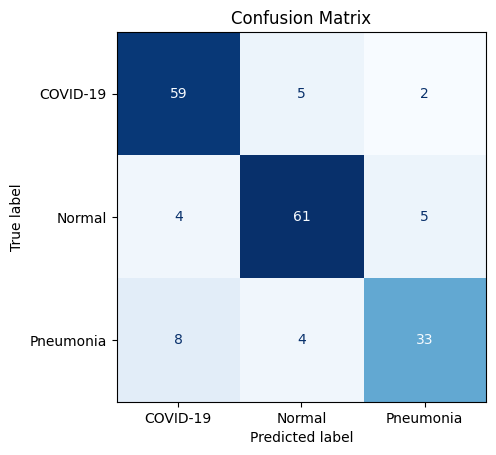

In [93]:
param_grid = {
    'max_depth': range(5, 101, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 5)
}

grid_search = GridSearchCV(
    rf_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm_rf, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
rf_glcm_top_10 = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(rf_glcm_top_10, X_test_glcm_rf, y_test_glcm)

### SVM on GLCM Features
We train a linear Support Vector Machine (SVM) on the GLCM features and evaluate its classification performance.

SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9656
      Normal     0.9631
   Pneumonia     0.9503

   macro avg     0.9597


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8955    0.9091    0.9023        66
      Normal     0.9118    0.8857    0.8986        70
   Pneumonia     0.8043    0.8222    0.8132        45

    accuracy                         0.8785       181
   macro avg     0.8705    0.8723    0.8713       181
weighted avg     0.8791    0.8785    0.8787       181



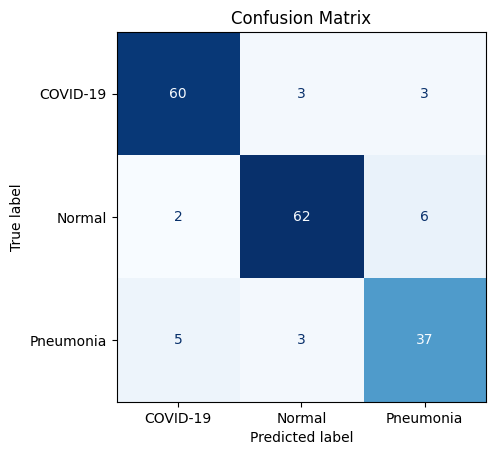

In [94]:
from sklearn.svm import SVC

svc_glcm = SVC(probability=True, random_state=RANDOM_STATE)

# Train the classifier
svc_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'C': np.float64(100.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'linear'}

Optimal F1-macro score: 0.8561724937324662
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9599
      Normal     0.9221
   Pneumonia     0.9459

   macro avg     0.9427


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9333    0.8485    0.8889        66
      Normal     0.8788    0.8286    0.8529        70
   Pneumonia     0.7636    0.9333    0.8400        45

    accuracy                         0.8619       181
   macro avg     0.8586    0.8701    0.8606       181
weighted avg     0.8700    0.8619    0.8628       181



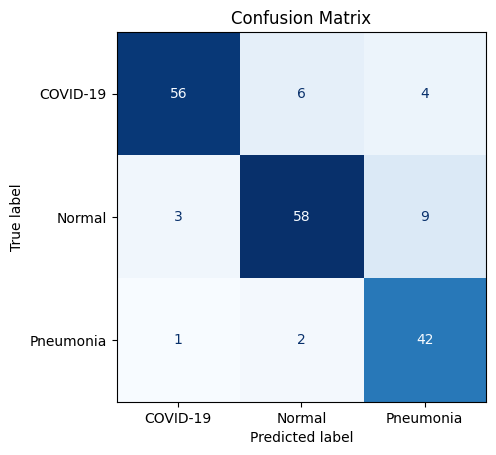

In [95]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7),
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(
    svc_glcm,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Finer grid search with smaller parameter space

Optimal Hyperparameters:
{'C': np.float64(100.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'linear'}

Optimal F1-macro score: 0.8561724937324662
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9599
      Normal     0.9221
   Pneumonia     0.9459

   macro avg     0.9427


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9333    0.8485    0.8889        66
      Normal     0.8788    0.8286    0.8529        70
   Pneumonia     0.7636    0.9333    0.8400        45

    accuracy                         0.8619       181
   macro avg     0.8586    0.8701    0.8606       181
weighted avg     0.8700    0.8619    0.8628       181



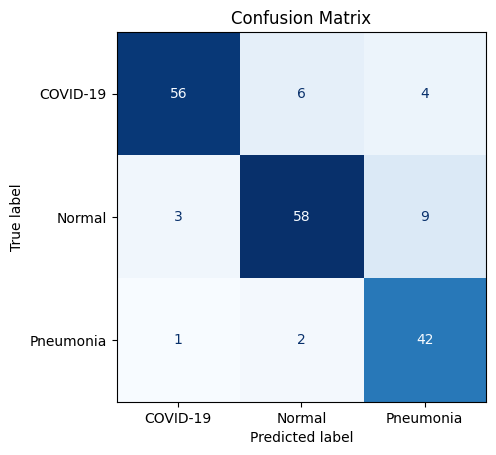

In [96]:
# Finer grid search around best values
fine_param_grid = {
    'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
    'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']  # Try with class weighting
}

fine_svm_gridsearch = GridSearchCV(
    svc_glcm,
    fine_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

fine_svm_gridsearch.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Permutation Feature Importance on Best SVM Model

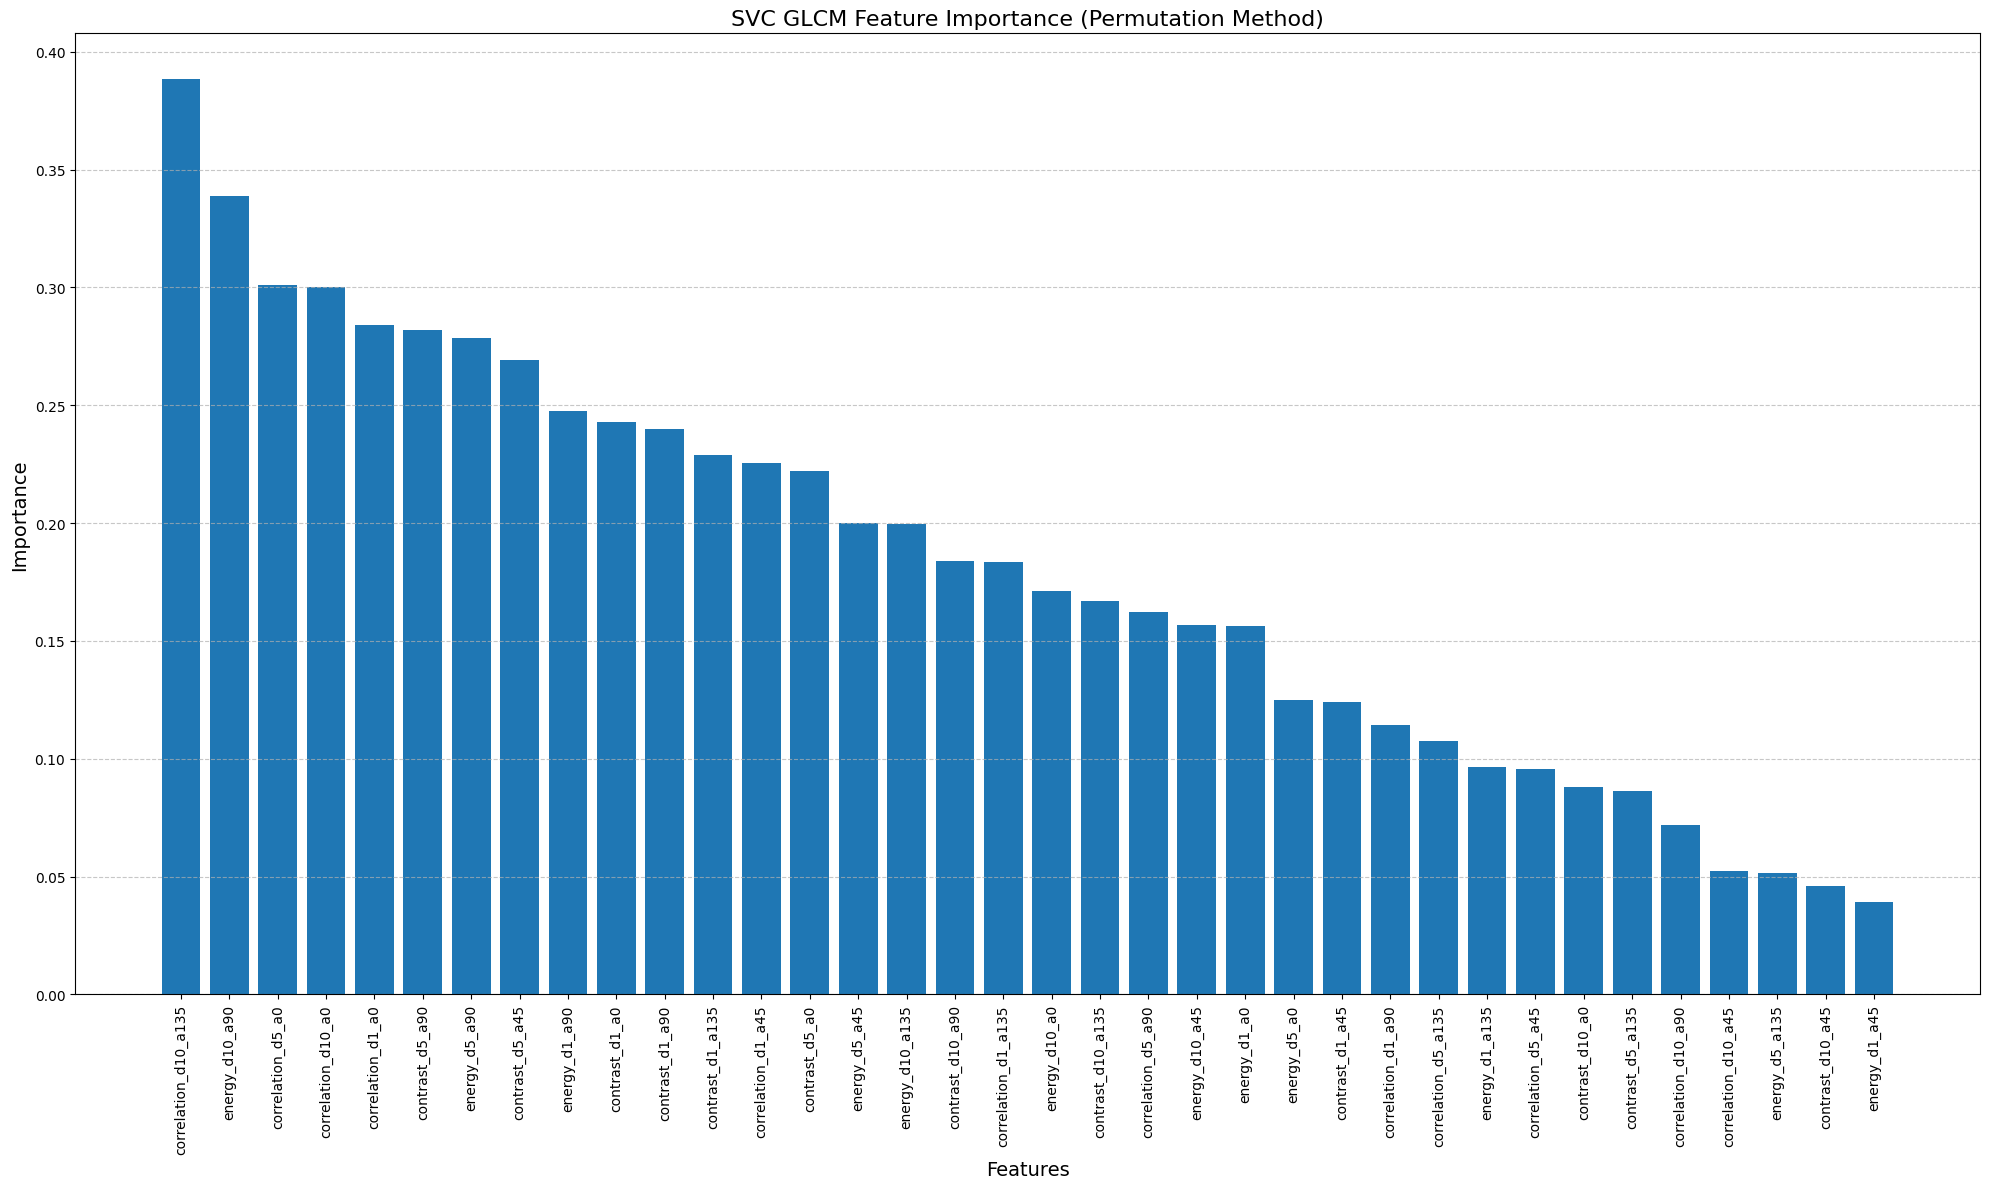

In [97]:
# permutation importance
result = permutation_importance(svc_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(svc_glcm, perm_importances, perm_indices, feature_names)

In [98]:
best_features = [feature_names[i] for i in perm_indices[:10]]
print(f"Best features: {best_features}")

# slice to 10 best features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_svc = X_train_glcm[:, perm_indices[:10]].copy()
X_test_glcm_svc = X_test_glcm[:, perm_indices[:10]].copy()

Best features: ['correlation_d10_a135', 'energy_d10_a90', 'correlation_d5_a0', 'correlation_d10_a0', 'correlation_d1_a0', 'contrast_d5_a90', 'energy_d5_a90', 'contrast_d5_a45', 'energy_d1_a90', 'contrast_d1_a0']


Optimal Hyperparameters:
{'C': np.float64(3593.813663804626), 'class_weight': None, 'gamma': np.float64(0.0002782559402207126), 'kernel': 'rbf'}

Optimal F1-macro score: 0.8235481854646712
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9802
      Normal     0.9014
   Pneumonia     0.9054

   macro avg     0.9290


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8939    0.8939    0.8939        66
      Normal     0.7538    0.7000    0.7259        70
   Pneumonia     0.6000    0.6667    0.6316        45

    accuracy                         0.7624       181
   macro avg     0.7493    0.7535    0.7505       181
weighted avg     0.7667    0.7624    0.7637       181



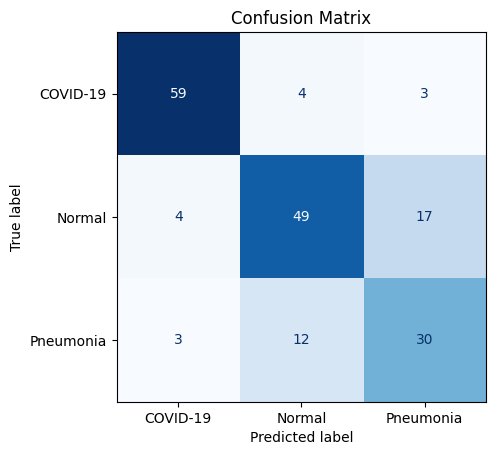

In [99]:
# Finer grid search around best values
fine_param_grid = {
    'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
    'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']  # Try with class weighting
}

fine_svm_gridsearch = GridSearchCV(
    svc_glcm,
    fine_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

fine_svm_gridsearch.fit(X_train_glcm_svc, y_train_glcm)

print("Optimal Hyperparameters:")
print(fine_svm_gridsearch.best_params_)

print(f"\nOptimal F1-macro score: {fine_svm_gridsearch.best_score_}")

# Set best estimator as model
svc_glcm_top_10 = fine_svm_gridsearch.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm_top_10, X_test_glcm_svc, y_test_glcm)

### k-Nearest Neighbors on GLCM Features
k-NN is tested again, this time using the texture-based features extracted from GLCM.

K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9164
      Normal     0.9401
   Pneumonia     0.8939

   macro avg     0.9168


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9153    0.8182    0.8640        66
      Normal     0.8228    0.9286    0.8725        70
   Pneumonia     0.7442    0.7111    0.7273        45

    accuracy                         0.8343       181
   macro avg     0.8274    0.8193    0.8213       181
weighted avg     0.8370    0.8343    0.8333       181



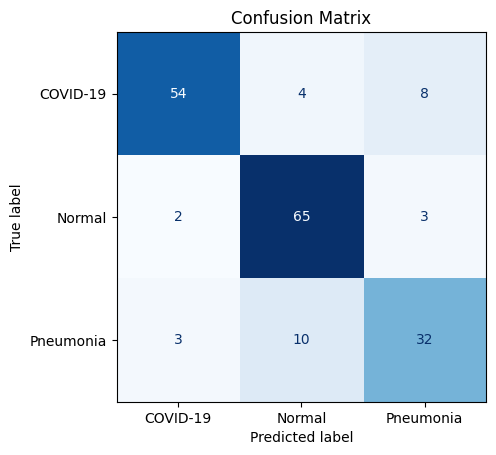

In [100]:
from sklearn.neighbors import KNeighborsClassifier

knn_glcm = KNeighborsClassifier()

# Train the classifier
knn_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(knn_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}

Optimal F1-macro score: 0.764690446124464
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9372
      Normal     0.9532
   Pneumonia     0.9039

   macro avg     0.9314


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9455    0.7879    0.8595        66
      Normal     0.8205    0.9143    0.8649        70
   Pneumonia     0.6875    0.7333    0.7097        45

    accuracy                         0.8232       181
   macro avg     0.8178    0.8118    0.8113       181
weighted avg     0.8330    0.8232    0.8243       181



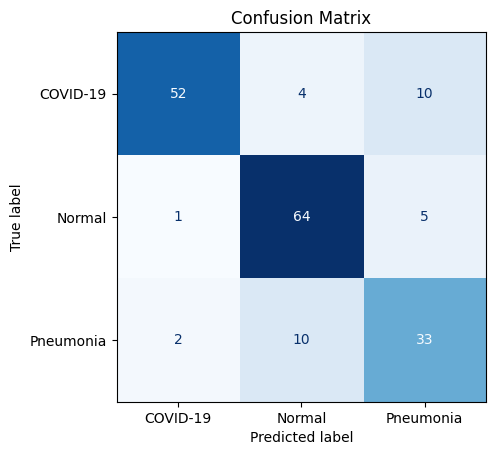

In [101]:
param_grid = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(
    knn_glcm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=0
)

grid_search.fit(X_train_glcm, y_train_glcm)

# Print the best hyperparameters and the corresponding score
print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Use the best model from the grid search
knn_glcm = grid_search.best_estimator_

# Get Results from the optimized model
get_model_analytics(knn_glcm, X_test_glcm, y_test_glcm)

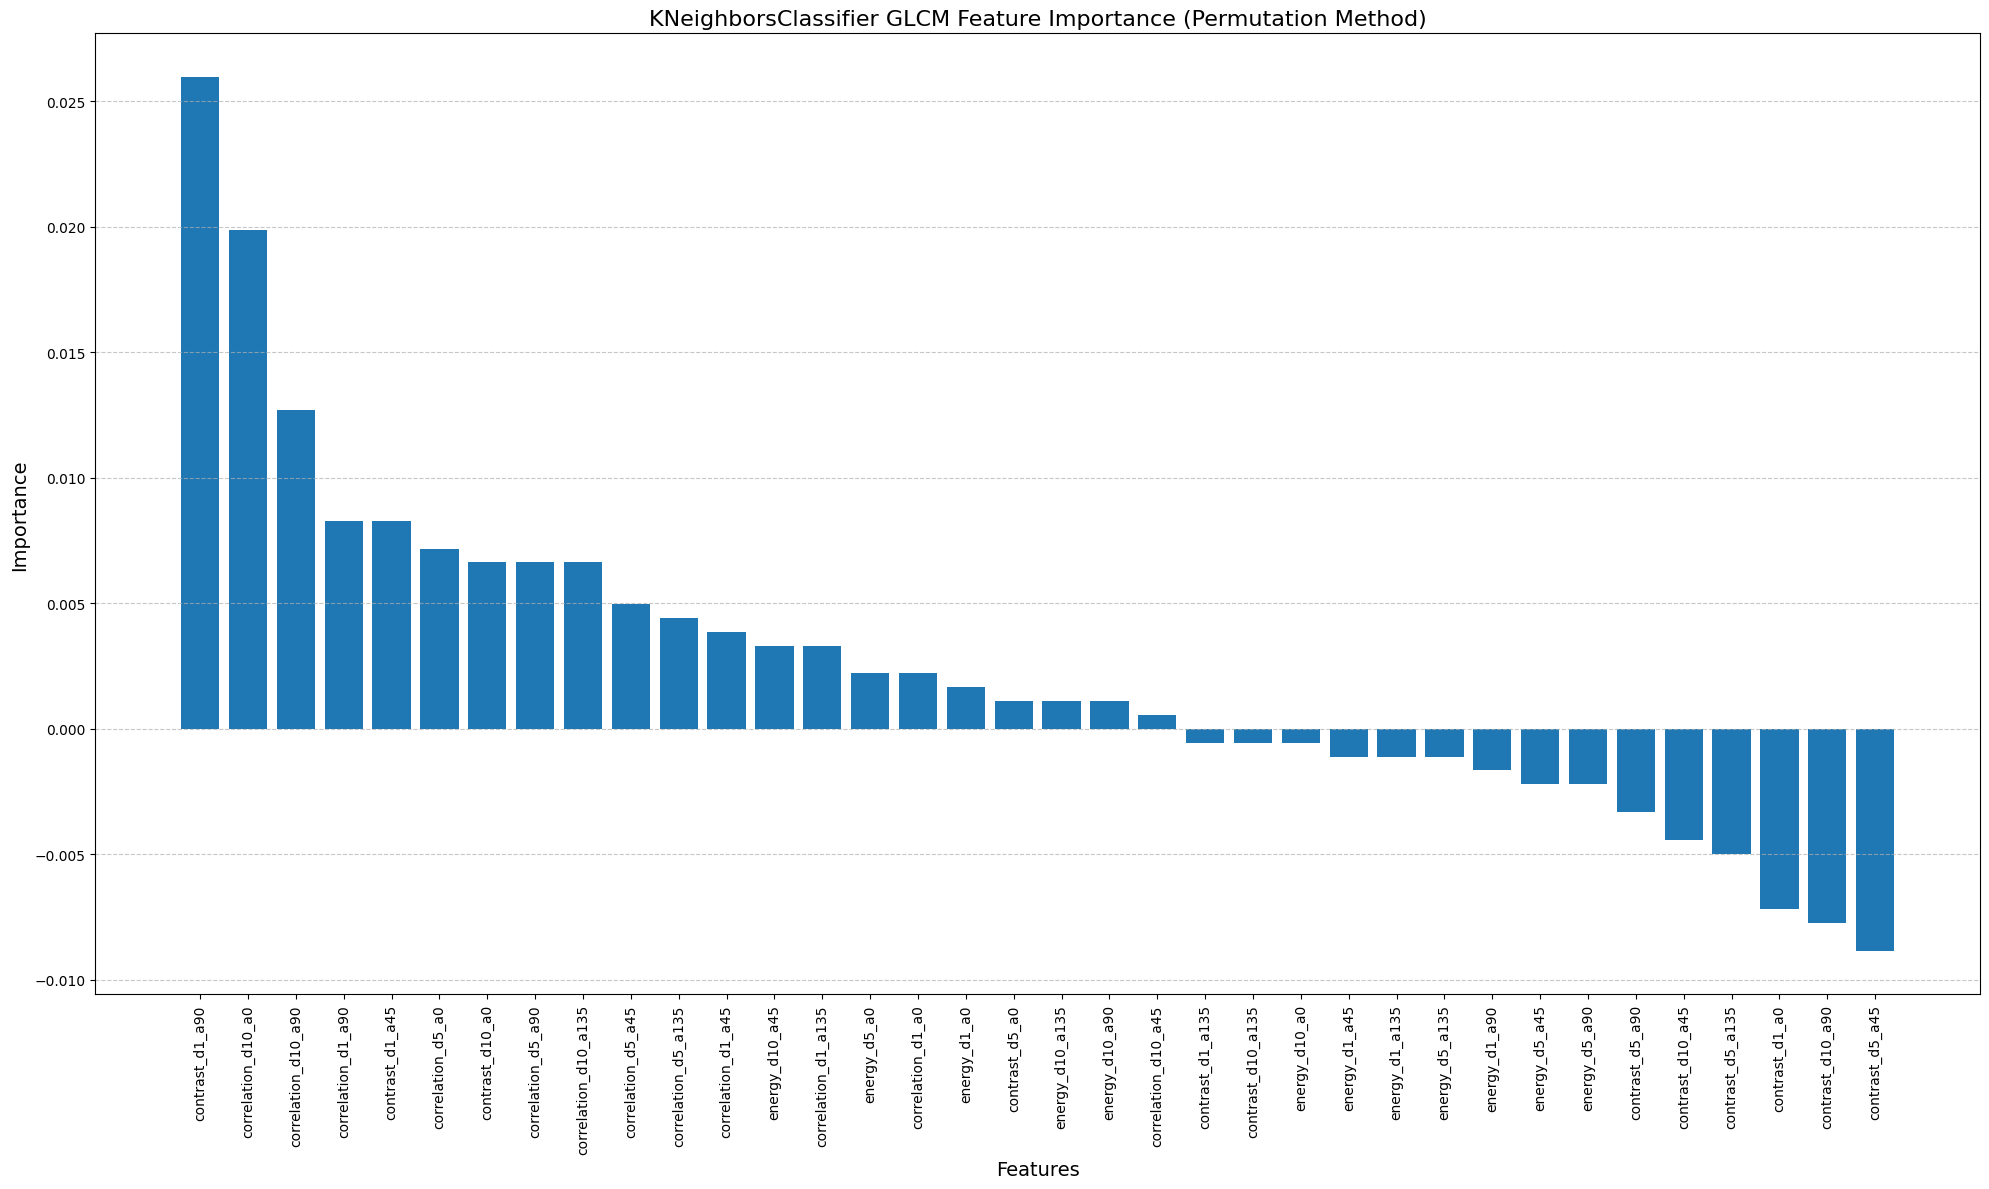

In [102]:
# permutation importance
result = permutation_importance(knn_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(knn_glcm, perm_importances, perm_indices, feature_names)

In [103]:
best_features = [feature_names[i] for i in perm_indices[:10]]
print(f"Best features: {best_features}")

# slice to 10 best features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_knn = X_train_glcm[:, perm_indices[:10]].copy()
X_test_glcm_knn = X_test_glcm[:, perm_indices[:10]].copy()

Best features: ['contrast_d1_a90', 'correlation_d10_a0', 'correlation_d10_a90', 'correlation_d1_a90', 'contrast_d1_a45', 'correlation_d5_a0', 'contrast_d10_a0', 'correlation_d5_a90', 'correlation_d10_a135', 'correlation_d5_a45']


Optimal Hyperparameters:
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

Optimal F1-macro score: 0.8313645753629799
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9738
      Normal     0.9401
   Pneumonia     0.9561

   macro avg     0.9567


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9661    0.8636    0.9120        66
      Normal     0.8696    0.8571    0.8633        70
   Pneumonia     0.7547    0.8889    0.8163        45

    accuracy                         0.8674       181
   macro avg     0.8635    0.8699    0.8639       181
weighted avg     0.8762    0.8674    0.8694       181



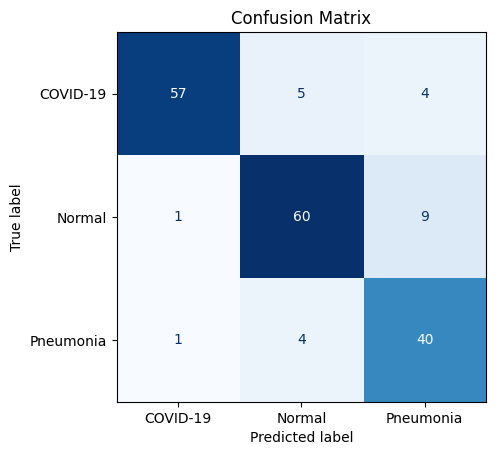

In [104]:
param_grid = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(
    knn_glcm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=0
)

grid_search.fit(X_train_glcm_knn, y_train_glcm)

# Print the best hyperparameters and the corresponding score
print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Use the best model from the grid search
knn_glcm_top_10 = grid_search.best_estimator_

# Get Results from the optimized model
get_model_analytics(knn_glcm_top_10, X_test_glcm_knn, y_test_glcm)

# Results

In [106]:
# Flat Data Row
output_columns = []
print("FLATTENED DATA MODELS")
run_model_analytics_in_column(lr_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(rf_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(svc_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(knn_flat, X_test_flat, y_test_flat, output_columns)
show_model_analytics_columns(output_columns)

# GLCM Data Row
output_columns = []
print("GLCM DATA MODELS")
run_model_analytics_in_column(lr_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(rf_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(knn_glcm, X_test_glcm, y_test_glcm, output_columns)
show_model_analytics_columns(output_columns)

# GLCM Data Top 10 Features Row
output_columns = []
print("GLCM DATA WITH TOP 10 FEATURES MODELS")
run_model_analytics_in_column(lr_glcm_top_10, X_test_glcm_lr, y_test_glcm, output_columns)
run_model_analytics_in_column(rf_glcm_top_10, X_test_glcm_rf, y_test_glcm, output_columns)
run_model_analytics_in_column(knn_glcm_top_10, X_test_glcm_knn, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm_top_10, X_test_glcm_svc, y_test_glcm, output_columns)
show_model_analytics_columns(output_columns)

FLATTENED DATA MODELS


GLCM DATA MODELS


GLCM DATA WITH TOP 10 FEATURES MODELS
